## Movie Recommendation System (User-Based Collaborative Filtering)

### Download the dataset and import relevant libraries

Download MovieLens 100K dataset: https://grouplens.org/datasets/movielens/100k/
<br>
About the dataset: 100,000 ratings from 943 users on 1,682 movies

Import necessary libraries for the project

In [1]:
## import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

## other settings
pd.options.display.max_columns = None # to avoid truncated outputs

In [2]:
ratings = pd.read_csv('ml-100k/u.data', sep='\t', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
## sanity check for 100k ratings from ~1k users and ~1.7k movies
print(f"Number of Unique Users: {ratings['userId'].nunique()}")
print(f"Number of Unique Movies: {ratings['movieId'].nunique()}")
print(f"Number of Ratings: {ratings.shape[0]}")

Number of Unique Users: 943
Number of Unique Movies: 1682
Number of Ratings: 100000


We don't really need the timestamp for this analysis so we'll drop it for now.

In [4]:
ratings = ratings.drop(columns=['timestamp'])
ratings.head()

,userId,movieId,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [5]:
## read genre data
genres = pd.read_csv('ml-100k/u.genre', sep='|', header=None, names=['genre', 'genreId'])
genres.head()

,genre,genreId
0,unknown,0
1,Action,1
2,Adventure,2
3,Animation,3
4,Children's,4


In [6]:
## read movies data
movies = pd.read_csv('ml-100k/u.item', sep='|', header=None, encoding='latin-1')
movies.columns = ['movieId', 'title', 'release_date', 'video_release_date', 'imdb_url'] + list(genres['genre'].unique())
movies.head()

,movieId,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


### Data Exploration (EDA)

Visualize rating distributions, user activity, genre popularity, etc.

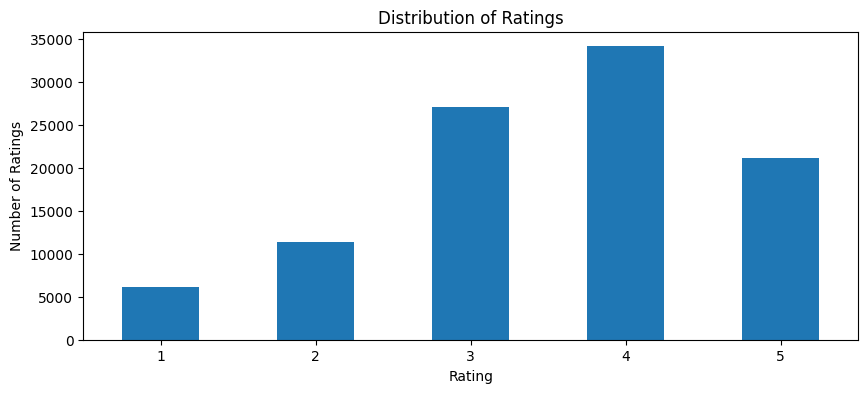

In [7]:
## rating distribution
fig, ax = plt.subplots(figsize=(10, 4))
counts = ratings['rating'].value_counts().sort_index()
counts.plot(kind='bar', ax=ax)
ax.set_title('Distribution of Ratings')
ax.set_xlabel('Rating')
ax.set_xticklabels(counts.index, rotation=0)
ax.set_ylabel('Number of Ratings')
plt.show()

Looking at the rating distribution, we see that most ratings are around 3-4 out of 5. The distribution is generally skewed toward the higher ratings.

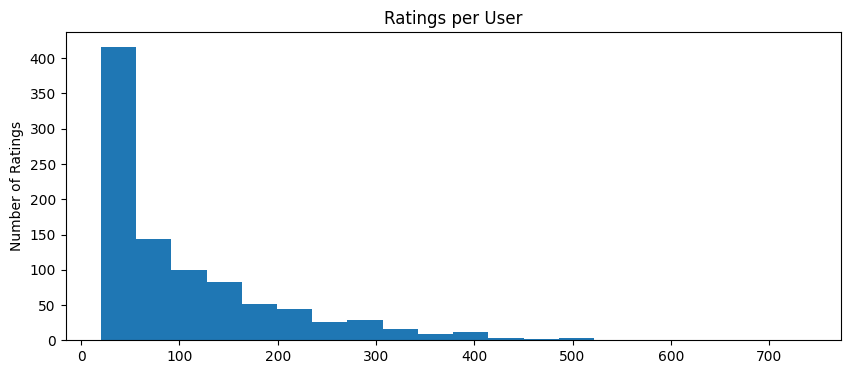

In [8]:
## user activity - how many ratings did each user give?
user_counts = ratings['userId'].value_counts()
fig, ax = plt.subplots(figsize=(10, 4))
user_counts.plot(kind='hist', bins=20, ax=ax)
ax.set_title('Ratings per User')
ax.set_ylabel('Number of Ratings')
plt.show()

From the above histogram, we observe that the users with larger user IDs e.g. beyond 500 had very few ratings.

We can also take a look at the lowest number of ratings by a user in the dataset...

In [9]:
ratings['userId'].value_counts().min()

20

At the least, each user in our dataset would have reviewed 20 movies.

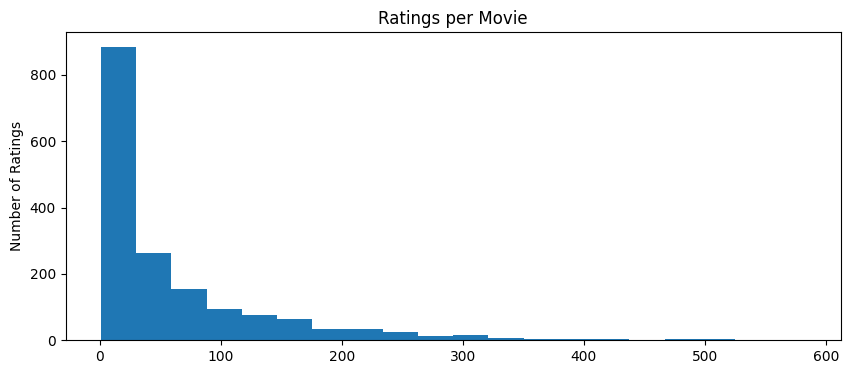

In [10]:
## movie popularity
movie_counts = ratings['movieId'].value_counts()
fig, ax = plt.subplots(figsize=(10, 4))
movie_counts.plot(kind='hist', bins=20, ax=ax)
ax.set_title('Ratings per Movie')
ax.set_ylabel('Number of Ratings')
plt.show()

In [11]:
## top 5 most rated movies
ratings['movieId'].value_counts().sort_values(ascending=False)[:5]

movieId
50     583
258    509
100    508
181    507
294    485
Name: count, dtype: int64

We can merge these movie IDs with the movies dataset to see their titles

In [12]:
pd.merge(ratings['movieId'].value_counts().sort_values(ascending=False)[:5], movies[['movieId', 'title']], on='movieId', how='left')

,movieId,count,title
0,50,583,Star Wars (1977)
1,258,509,Contact (1997)
2,100,508,Fargo (1996)
3,181,507,Return of the Jedi (1983)
4,294,485,Liar Liar (1997)


Here we see that the top 5 most rated movies are:
1. Star Wars (1977)
2. Contact (1997)
3. Fargo (1996)
4. Return of the Jedi (1983)
5. Liar Liar (1997)

We could go one step deeper and identify the genres associated with these movies

In [13]:
top_5_movies_genres = movies[movies['movieId'].isin([50, 258, 100, 181, 294])]
top_5_movies_genres

,movieId,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
49,50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
99,100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
180,181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
257,258,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
293,294,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
top_5_movies_genres.iloc[:, 5:].sum(axis=0).sort_values(ascending=False)

Sci-Fi         3
Adventure      2
War            2
Drama          2
Action         2
Romance        2
Thriller       1
Comedy         1
Crime          1
unknown        0
Musical        0
Mystery        0
Fantasy        0
Horror         0
Film-Noir      0
Documentary    0
Children's     0
Animation      0
Western        0
dtype: int64

Of the top 5 movies that were identified as top 5 movie genres, sci-fi tops the list, followed by adventure, war, drama, action, romance.

We can also take a look at the sparsity of the user-item matrix.

In [15]:
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
num_ratings = len(ratings)

sparsity = 1 - (num_ratings / (num_users * num_movies))
print(f'Sparsity of user-movie matrix: {sparsity:.2%}')

Sparsity of user-movie matrix: 93.70%


The sparsity of the user-movie matrix is very high at 93.7%, suggesting that most user-movie pairs are unrated. This could affect similarity calculations.

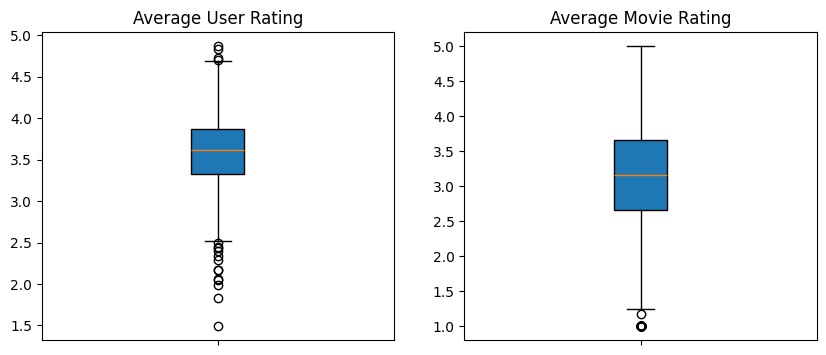

In [16]:
avg_rating_user = ratings.groupby('userId')['rating'].mean()
avg_rating_movie = ratings.groupby('movieId')['rating'].mean()
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].boxplot(avg_rating_user, patch_artist=True)
ax[1].boxplot(avg_rating_movie, patch_artist=True)
ax[0].set_xticklabels('')
ax[1].set_xticklabels('')
ax[0].set_title('Average User Rating')
ax[1].set_title('Average Movie Rating')
plt.show()

From the boxplots above, we can confirm that most ratings are between 3-4 with a skew towards the higher end of the scale as previously seen inthe distribution plot.

We also observe that the average rating for a movie ranges from 1-5, with most movies having an average of 3-4 rating. There are a few instances where movies were rated more extremely. We can take a look at these.

In [17]:
agg_movies = ratings.groupby('movieId')['rating'].agg(['mean', 'count'])
singular_movies = agg_movies[((agg_movies['mean']==5) | (agg_movies['mean']==1)) & (agg_movies['count']==1)]
singular_movies

,mean,count
movieId,,
599,1.0,1
814,5.0,1
830,1.0,1
852,1.0,1
1122,5.0,1
...,...,...
1654,1.0,1
1659,1.0,1
1661,1.0,1


Here we observe that there are 64 movies that only had 1 rating on either extreme end of the scale e.g. 1 or 5. This could add to sparsity of the user-movie matrix which could negatively affect similarity calculations, and we could consider removing them in our analysis.

In [18]:
ratings_clean = ratings[~ratings['movieId'].isin(singular_movies.index)]
ratings_clean.shape

(99936, 3)

### Model Building & Evaluation

- Build a baseline model using user average
- Evaluate with RMSE and MAE
- Compare with Pearson correlation, matrix factorization (SVD) model & the `Surprise` package's KNN-based collaborative filtering models

#### Baseline Model - User Average
As a baseline model, we'll predict the rating a user will give to an unseen movie using the user's mean rating.

In [19]:
## start with a baseline model using user average rating
def baseline_predict(user_id, train_df):
    return train_df[train_df['userId']==user_id]['rating'].mean()

In [20]:
## 5-fold CV
rmse_list = []
mae_list = []

for i in range(1, 6):
    train_df = pd.read_csv(f'ml-100k/u{i}.base', sep='\t', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])
    test_df = pd.read_csv(f'ml-100k/u{i}.test', sep='\t', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])
    
    preds = test_df.apply(lambda row: baseline_predict(row['userId'], train_df), axis=1)

    rmse = np.sqrt(mean_squared_error(test_df['rating'], preds))
    rmse_list.append(rmse)
    mae = mean_absolute_error(test_df['rating'], preds)
    mae_list.append(mae)

print(f'Baseline RMSE: {np.mean(rmse_list):.4f}')
print(f'Baseline MAE: {np.mean(mae_list):.4f}')

Baseline RMSE: 1.0437
Baseline MAE: 0.8362


Although the user average seems to perform rather well, it doesn't capture personal preferences beyond general tendencies. 

#### Manual Pearson Similarity

Next, we'll take a look at using Pearson correlation to calculate similarity to predict ratings. We will focus on Pearson rather than cosine similarity here because cosine tends to be sensitive to sparsity which could result in unreliable similarity scores and it doesn't account for rating scale differences / biases e.g. one user rates generously, another harshly.

In [21]:
## pearson similarity function
def pearson_similarity(user1, user2, user_movie_df):
    u1 = user_movie_df.loc[user1]
    u2 = user_movie_df.loc[user2]
    common_movies = u1.dropna().index.intersection(u2.dropna().index)

    if len(common_movies) < 2:
        return 0 # pearson requires at least 2 data points to work

    u1_norm = u1[common_movies] - u1[common_movies].mean()
    u2_norm = u2[common_movies] - u2[common_movies].mean()

    numerator = np.dot(u1_norm, u2_norm)
    denominator = np.sqrt(np.sum(u1_norm**2)) * np.sqrt(np.sum(u2_norm**2))

    return numerator / denominator if denominator != 0 else 0

In [22]:
## predict rating for user-movie pair
def predict_rating(user, movie, user_movie_df, k=5):
    # address cold start problem
    if user not in user_movie_df.index:
        return user_movie_df.stack().mean()

    similarities = []
    for other_user in user_movie_df.index:
        if other_user == user:
            continue
        if movie in user_movie_df.columns and pd.notna(user_movie_df.loc[other_user, movie]):
            sim = pearson_similarity(user, other_user, user_movie_df)
            similarities.append((sim, user_movie_df.loc[other_user, movie]))

    # sort by decreasing similarity, get top k
    similarities = sorted(similarities, key=lambda x: x[0], reverse=True)[:k]

    if not similarities:
        return user_movie_df.loc[user].mean() # fallback

    numerator = sum(sim * rating for sim, rating in similarities)
    denominator = sum(abs(sim) for sim, _ in similarities)

    return numerator / denominator if denominator != 0 else user_movie_df.loc[user].mean()

In [23]:
## 5-fold CV
rmse_list = []
mae_list = []

for i in range(1, 6):
    train_df = pd.read_csv(f'ml-100k/u{i}.base', sep='\t', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])
    test_df = pd.read_csv(f'ml-100k/u{i}.test', sep='\t', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])

    train_matrix = train_df.pivot_table(index='userId', columns='movieId', values='rating')
    
    predictions = []
    actuals = []

    for idx, (user, movie, actual) in enumerate(zip(test_df['userId'], test_df['movieId'], test_df['rating'])):
        pred = predict_rating(user, movie, train_matrix)
        predictions.append(pred)
        actuals.append(actual)

        if idx % 100 == 0:
            print(f'Fold {i}, processed {idx} ratings...')
    
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_list.append(rmse)
    mae = mean_absolute_error(actuals, predictions)
    mae_list.append(mae)

print(f'Overall Model RMSE: {np.mean(rmse_list):.4f}')
print(f'Overall Model MAE: {np.mean(mae_list):.4f}')

Fold 1, processed 0 ratings...
Fold 1, processed 100 ratings...
Fold 1, processed 200 ratings...
Fold 1, processed 300 ratings...
Fold 1, processed 400 ratings...
Fold 1, processed 500 ratings...
Fold 1, processed 600 ratings...
Fold 1, processed 700 ratings...
Fold 1, processed 800 ratings...
Fold 1, processed 900 ratings...
Fold 1, processed 1000 ratings...
Fold 1, processed 1100 ratings...
Fold 1, processed 1200 ratings...
Fold 1, processed 1300 ratings...
Fold 1, processed 1400 ratings...
Fold 1, processed 1500 ratings...
Fold 1, processed 1600 ratings...
Fold 1, processed 1700 ratings...
Fold 1, processed 1800 ratings...
Fold 1, processed 1900 ratings...
Fold 1, processed 2000 ratings...
Fold 1, processed 2100 ratings...
Fold 1, processed 2200 ratings...
Fold 1, processed 2300 ratings...
Fold 1, processed 2400 ratings...
Fold 1, processed 2500 ratings...
Fold 1, processed 2600 ratings...
Fold 1, processed 2700 ratings...
Fold 1, processed 2800 ratings...
Fold 1, processed 2900 rat

<hr>

#### Surprise package - KNNBasic

- Find k nearest neighbors to target user using Pearson correlation
- Select neighbors who have rated movie in question
- Average their ratings for movie in question, weighted by similarity

In [36]:
from surprise import KNNBasic, KNNWithMeans, SVD
from surprise import Dataset, Reader, accuracy

def surprise_model_evaluation(model):
    ## 5-fold CV
    rmse_list = []
    mae_list = []
    
    for i in range(1, 6):
        train_df = pd.read_csv(f'ml-100k/u{i}.base', sep='\t', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])
        test_df = pd.read_csv(f'ml-100k/u{i}.test', sep='\t', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])
    
        reader = Reader(rating_scale=(train_df.rating.min(), train_df.rating.max()))
    
        # load dataframe into surprise format
        train_data = Dataset.load_from_df(train_df[['userId', 'movieId', 'rating']], reader)
        # build trainset
        trainset = train_data.build_full_trainset()
        # convert test df accordingly
        testset = list(zip(test_df['userId'], test_df['movieId'], test_df['rating']))
        
        model.fit(trainset)
        
        # predict
        predictions = model.test(testset)
        rmse = accuracy.rmse(predictions)
        rmse_list.append(rmse)
        mae = accuracy.mae(predictions)
        mae_list.append(mae)
    
    print(f'\nOverall Model RMSE: {np.mean(rmse_list):.4f}')
    print(f'Overall Model MAE: {np.mean(mae_list):.4f}')

    return model

In [37]:
sim_options = {
    'name': 'pearson_baseline',
    'user-based': True
}
surprise_model_evaluation(KNNBasic(k=5, sim_options=sim_options))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0571
MAE:  0.8369
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0537
MAE:  0.8291
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0471
MAE:  0.8241
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0446
MAE:  0.8233
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 1.0563
MAE:  0.8344

Overall Model RMSE: 1.0517
Overall Model MAE: 0.8295


<hr>

#### Surprise package - KNNWithMeans

This model predicts a user's rating by averaging the ratings of similar users, adjusted by their individual rating biases (accounting for users who tend to rate higher or lower than others consistently). Here, we used Pearson correlation to measure similarity, and added user means to account for different rating habits.

- Find k nearest neighbors to target user using Pearson correlation
- Select neighbors who have rated movie in question
- For each neighbor, compute how much they rated movie in question above / below their average
- Weight these deviations by similarity
- Add the result to target user's average rating

In [38]:
surprise_model_evaluation(KNNWithMeans(k=5, sim_options=sim_options))

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9896
MAE:  0.7693
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9874
MAE:  0.7642
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9818
MAE:  0.7608
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9829
MAE:  0.7617
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9817
MAE:  0.7663

Overall Model RMSE: 0.9847
Overall Model MAE: 0.7644


<hr>

#### Surprise package - SVD

SVD is a matrix factorization technique that decomposes the user-item rating matrix into latent features. It learns hidden patterns like genre preferences or rating tendencies without needing explicit metadata. It's more ronust to sparsity than similarity-based methods.

In [39]:
svd = surprise_model_evaluation(SVD(random_state=42))

RMSE: 0.9561
MAE:  0.7524
RMSE: 0.9378
MAE:  0.7366
RMSE: 0.9322
MAE:  0.7340
RMSE: 0.9301
MAE:  0.7340
RMSE: 0.9327
MAE:  0.7405

Overall Model RMSE: 0.9378
Overall Model MAE: 0.7395


### Recommendation Demo

In [40]:
def recommend_movies(user_id, n=3):
    user_movie_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')
    user_df = user_movie_matrix.loc[user_id]
    unseen_movies = user_df[user_df.isna()].index
    
    testset = list(zip(test_df['userId'], test_df['movieId'], test_df['rating']))
    
    predicted_ratings = {movie: svd.predict(user_id, movie) for movie in unseen_movies}
    top_3 = sorted(predicted_ratings.items(), key=lambda x: x[1].est, reverse=True)[:3]

    for i, m in enumerate(top_3):
        print(f"{i+1}. {movies[movies['movieId'] == m[0]]['title'].values[0]}")

In [41]:
print('Top 3 Movie Recommendations for User 1\n')
recommend_movies(1)

Top 3 Movie Recommendations for User 1

1. Chinatown (1974)
2. North by Northwest (1959)
3. Sunset Blvd. (1950)
